In [1]:
import pandas as pd
import os
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score

In [3]:
# To make nice plot for Latex
%matplotlib notebook
plt.rcParams.update({'font.size': 13}) # for Latex
plt.rcParams['figure.figsize'] = [10, 5]

# Building the dataset

Let's first load the data. To do so, you must have a features folder where networks features have been generated. In this section, we will only load some of this networks matching the property we want. Here it will be networks generated with 1000 nodes. 

To build our dataset, we merged all the nodes features from all network in one big dataset like in the paper. If you use the generator file, your network should be generated with the same parameters as in the paper. Then we split the dataset in two to have a train and a test dataset. The split is made like all nodes from the same network are in the same dataset.

In [4]:
path_feats = "../features/"
print("Make sure your features folder is at : {}".format(os.path.join(os.getcwd(), path_feats)))

Make sure your features folder is at : /home/nicolas/Desktop/Anomaly-detection-ENSAE/examples/../features/


In [5]:
def pick_feats(n, w = None, p = None, path_feats = "features/"):
    '''Loads the features stored in the folder path_feats.
        It only loads the features with the good parameters (n, w, p).
        Params :
            n: number of nodes of the network
            w: weight parameters of the network at generation
            p: probability parameters of the network at generation
        Return a dataframe of all networks' features merged '''
    df = pd.DataFrame()
    n_net = 0
    for file in os.listdir(path_feats):
        if file[0] != "G" and (n is None or "n{}_".format(n) in file)\
                          and (w is None or "w{}_".format(w) in file)\
                          and (p is None or "p{}_".format(p) in file):
            df_net = pd.read_pickle(os.path.join(path_feats, file))
            df_net["net_id"] = n_net
            df = df.append(df_net, ignore_index = True)
            n_net += 1
    return df

In [6]:
def split_net(df, test_prop = 0.2):
    '''Split a dataframe of features in two set while keeping each network integrity.
        ie: all nodes of the same network are put in the same dataset (train or test)
    '''
    net_ids = df.net_id.unique()
    n_net = len(net_ids) 
    test_net = np.random.choice(net_ids, int(max(round((test_prop)*n_net), 1)))
    selector = df.net_id.isin(test_net)
    df_train = df.loc[~selector]
    df_test = df.loc[selector]
    return df_train, df_test

In [7]:
df = pick_feats(n = 1000, path_feats=path_feats) # Load all the features of network with more than 1000 nodes
# df = df.replace([np.inf, -np.inf, np.nan], 0) # Sometimes necessary when path_size return inf
df.shape

(31000, 94)

In [8]:
df_train, df_test = split_net(df, test_prop=0.2) # Split the dataset to a train and a test
df_test.shape, df_train.shape

((6000, 94), (25000, 94))

It took 12 hours to generate this dataset and we only have 31 000 nodes. This dataset is pretty small compared to the paper with millions of nodes. However it already gives good results like in the paper.

# Fitting

Like in the paper, we use the RandomForest to detect anomalies. The fitting could be optimize by tuning hyper-parameters or choosing another classifier. We did not focus on this optimization to be able to compare our implementation with the paper. Moreover, we focus on optimizing our code without such work it would not have been possible to generate so much networks.

In [9]:
drop_columns = ["w", "n", "p", "net_id", "anomaly"] # Columns that are not features for the models

In [10]:
clf = RandomForestClassifier(n_estimators=100) # The classifier

In [11]:
clf.fit(df_train.drop(drop_columns, axis = 1), df_train.anomaly) # Fitting

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Score

The model is fitted, let's look at its performance. We looked at the precision and the recall metrics has the dataset is pretty unbalanced. You can see below that the model has pretty good performance around 80-90%. However the recall is not so high around 30-40%. The performance has some variance due to the smallness of our dataset.

This model is used to detect anomalies in financial networks. Then this anomalies are checked manually, thus having a high precision is very important to not make people waste time. However, for the time taken to run the model on a network we could have expected better recall.

In [12]:
Y_test_pred = clf.predict(df_test.drop(drop_columns, axis = 1))
Y_test = df_test.anomaly

In [13]:
prec, rec = precision_score(Y_test, Y_test_pred), recall_score(Y_test, Y_test_pred)
print("Score for {} nodes :".format(df_test.shape[0]))
print("\tPrecision : {}".format(prec))
print("\tRecall : {}".format(rec))

Score for 6000 nodes :
	Precision : 0.9375
	Recall : 0.4031117397454031


# Features importance

The paper is building a lot of features. They are splitted in 5 modules. Someone could ask if they are all usefull. So we are going to look at the features importance. To do so, we just use the provided features importances measure of scikit.

## Top 10 features

In [14]:
feats_imp = pd.Series(clf.feature_importances_, index = df_test.drop(drop_columns, axis = 1).columns)
feats_imp.sort_values(ascending=False)[:10]

statistics_1_score_1    0.067448
statistics_2_score_1    0.045341
statistics_2_score_2    0.041498
path_size_3             0.039497
com_GAW_penalized       0.038331
com_GAW_rel             0.037078
lower_sym_EXP_g1        0.036500
upper_comb_EXP_g1       0.036262
lower_rw_EXP_g1         0.036203
upper_sym_EXP_g1        0.035871
dtype: float64

NetEMD statistics are the most relevant followed by communities and localisations. This is reassuring as this features takes the most time to compute. This also confims that as seen in classes the Laplacian matrix contains information about the network structure. Moreover, its convex relaxation by finding the eigenvalue is efficient here.

## Features importance by module

In [15]:
# Here we build a dataframe containing the characteristics of each features
# Its importance and its modules

# Building the dataframe index
feats = pd.Series(df_test.drop("anomaly", axis = 1).columns.values, name="name")
feats = feats.to_frame()

# Assigning a type (module) to each variable name just by doing some matching
feats["type"] = "Other"
feats.loc[feats["name"].str.contains("^lower_rw_|upper_comb_|lower_sym_|upper_sym_"), "type"] = "loc"
feats.loc[feats["name"].str.contains("^path_size_"), "type"] = "path"
feats.loc[feats["name"].str.contains("^com_"), "type"] = "com"
feats.loc[feats["name"].str.contains("^GAW_"), "type"] = "GAW"
feats.loc[feats["name"].str.contains("^statistics_"), "type"] = "net_emd"
feats["type"] = feats["type"].astype('category') # to category to save computation

feats = feats.set_index("name")
feats["imp"] = feats_imp # Adding importance

feats = feats.sort_values("imp", ascending = False) # Sorting by importance

<IPython.core.display.Javascript object>


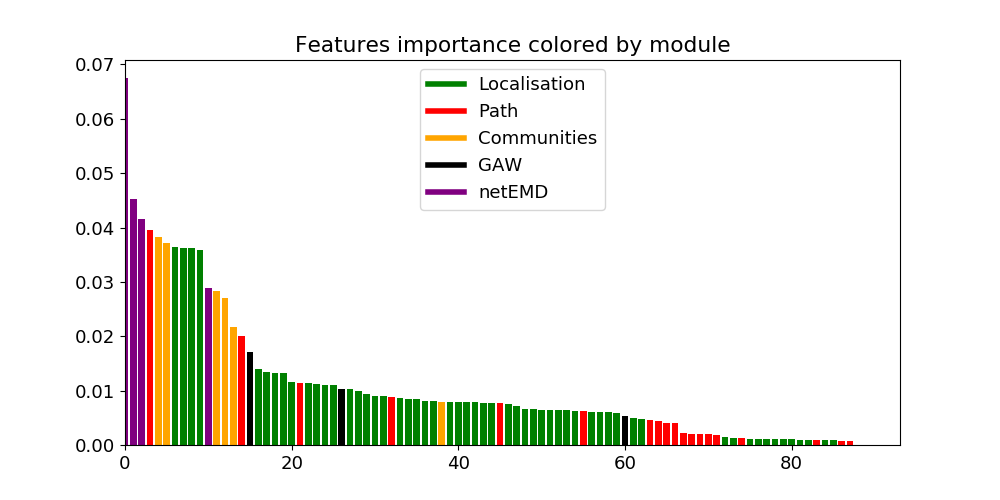

In [16]:
# Here we plot the importance by module 

plt.figure()
n_feats = len(feats.imp)
# Assigning color to each module
colors = feats["type"].map({"loc" : "green",
                            "path" : "red",
                            "com" : "orange",
                            "GAW" : "black",
                            "net_emd" : "purple",
                            "Other" : "yellow"})

# Plotting the bar of features importance
plt.bar(range(n_feats), feats.imp.values, color = colors)
plt.xlim(0, n_feats)
plt.title("Features importance colored by module")

# Building legends for each modules
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="orange", lw=4),
                Line2D([0], [0], color="black", lw=4),
                Line2D([0], [0], color="purple", lw=4),
               ]
plt.gca().legend(custom_lines, ['Localisation', "Path", "Communities", "GAW", "netEMD"])

You can clearly see that the netEMD features are above all. Moreover communities features are also pretty good while being cheap to compute. Also not all localisation features are relevant, it seems the exponential norm is the best rather than the IPR. It would be relevant for next time to only compute the exponential norm.

# Conclusion

This paper took us a lot of time to implement. Its computation is very expensive for each network thus we spent a lot of time finding ways of optimizing its computation. For example, we find way to use numpy broadcasting features to compute quickly GAW, Communities and localisation features. However as the number of null test is important it still takes a lot of time to compute it for each network.

This paper is interesting as its uses many techniches to detect anomalies. Each module is pretty independant and uses its own way to detect anomalies. All are relying heavily on the detection of communities and uses convex relaxation. We see here that this is pretty efficient with 80-90% precision.

However it is important to highlight that this results are done with generated networks. It would be great to find a real-dataset to test this module. Here, the network is generated in a controlled way by the authors, thus better performance could have been expected. This module spent a lot of time computing statistics at nodes level thus it is not surprising that it can detect the small structure inserted at generation. However, it is probable that with bigger structure the netEMD would not be performing so well.